This notebook is adapted from https://colab.research.google.com/drive/1yIlPo5CAjYrqWHeFEZrMlzWNCoNJ6_YP#scrollTo=eQwLElKmaowu

In [137]:
import jax
jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_debug_nans", True)
import jax.numpy as jnp
from jax.example_libraries.stax import Dense, Softplus, serial
# from jax.nn import relu
import pandas as pd
import optax

In [138]:
def layer(transform):

    def init_fun(rng, input_dim):
        cutoff = input_dim // 2
        perm = jnp.arange(input_dim)[::-1]
        params, trans_fun = transform(rng, cutoff, 2 * (input_dim - cutoff))

        def direct_fun(params, inputs):
            lower, upper = inputs[:, :cutoff], inputs[:, cutoff:]

            log_weight, bias = jnp.array_split(trans_fun(params, lower), 2, axis=1)
            upper = upper * jnp.exp(log_weight) + bias

            outputs = jnp.concatenate([lower, upper], axis=1)
            return outputs[:,perm]

        def inverse_fun(params, inputs):
            inputs = inputs[:, perm]
            lower, upper = inputs[:, :cutoff], inputs[:, cutoff:]

            log_weight, bias = jnp.array_split(trans_fun(params, lower), 2, axis=1)
            upper = (upper - bias) * jnp.exp(-log_weight)

            outputs = jnp.concatenate([lower, upper], axis=1)
            return outputs

        return params, direct_fun, inverse_fun

    return init_fun

In [139]:
def RealNVP(transform, n: int):

    def init_fun(rng, input_dim):

        all_params, direct_funs, inverse_funs = [], [], []
        for _ in range(n):
            rng, layer_rng = jax.random.split(rng)
            init_fun = layer(transform)
            param, direct_fun, inverse_fun = init_fun(layer_rng, input_dim)

            all_params.append(param)
            direct_funs.append(direct_fun)
            inverse_funs.append(inverse_fun)

        def feed_forward(params, apply_funs, inputs):
            for apply_fun, param in zip(apply_funs, params):
                inputs = apply_fun(param, inputs)
            return inputs

        def direct_fun(params, inputs):
            return feed_forward(params, direct_funs, inputs)

        def inverse_fun(params, inputs):
            return feed_forward(reversed(params), reversed(inverse_funs), inputs)

        return all_params, direct_fun, inverse_fun

    return init_fun

In [140]:
def harmonic_potential(tau, u0):
    return jnp.linalg.norm(tau) + u0

In [141]:
def make_error_loss(flow_forward, data_file):
    data = pd.read_csv(data_file)
    inputs = jnp.array([[jnp.exp(-r1), jnp.exp(-r2), jnp.cos(theta)] for r1, r2, theta in zip(data["r1"], data["r2"], data["theta"])])
    energy = jnp.array(data["energy"]) / 1e4
    batch_decoupled_energy = jax.vmap(harmonic_potential, (0, None), 0)

    def loss(params, u0):
        outputs = flow_forward(params, inputs)
        decoupled_energy = batch_decoupled_energy(outputs, u0)
        return jnp.mean( (decoupled_energy - energy) ** 2 )
    
    return loss

In [142]:
dim = 3
nlayers = 8
rng = jax.random.PRNGKey(42)

def transform(rng, cutoff: int, other: int):
            net_init, net_apply = serial(Dense(16), Softplus, Dense(16), Softplus, Dense(other))
            in_shape = (-1, cutoff)
            out_shape, net_params = net_init(rng, in_shape)
            return net_params, net_apply

flow_init = RealNVP(transform, nlayers)

init_rng, rng = jax.random.split(rng)
params, flow_forward, flow_inverse = flow_init(init_rng, dim)

loss = make_error_loss(flow_forward, "../h2opes/h2opes_analytic_train.txt")
valid_loss = make_error_loss(flow_forward, "../h2opes/h2opes_analytic_valid.txt")
test_loss = make_error_loss(flow_forward, "../h2opes/h2opes_analytic_test.txt")
value_and_grad = jax.value_and_grad(loss, argnums=(0, 1), has_aux=False)

params_step_size = 1e-4
params_optimizer = optax.adam(params_step_size)
params_opt_state = params_optimizer.init(params)

u0 = 0.5
u0_step_size = 1e-4
u0_optimizer = optax.adam(u0_step_size)
u0_opt_state = u0_optimizer.init(u0)

In [143]:
@jax.jit
def step(params, u0, params_opt_state, u0_opt_state):
    value, grad = value_and_grad(params, u0)
    params_grad, u0_grad = grad
    params_updates, params_opt_state = params_optimizer.update(params_grad, params_opt_state)
    u0_updates, u0_opt_state = u0_optimizer.update(u0_grad, u0_opt_state)
    params = optax.apply_updates(params, params_updates)
    u0 = optax.apply_updates(u0, u0_updates)
    return value, params, u0, params_opt_state, u0_opt_state

In [144]:
train_loss_history = []
valid_loss_history = []
# test_loss_history = []
nsteps = 6000
for i in range(nsteps):
    value, params, u0, params_opt_state, u0_opt_state = step(params, u0, params_opt_state, u0_opt_state)
    train_loss_history.append(value)
    valid_loss_history.append(valid_loss(params, u0))
    # test_loss_history.append(test_loss(params, u0))
    # print(i, value)
# print(u0)
print(test_loss(params, u0))
output = flow_inverse(params, jnp.array([[0, 0, 0]]))

0.06500807063014277


/var/folders/hf/60jhbx_s40b92cvfxl5gbbb80000gn/T/ipykernel_4844/1486418869.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


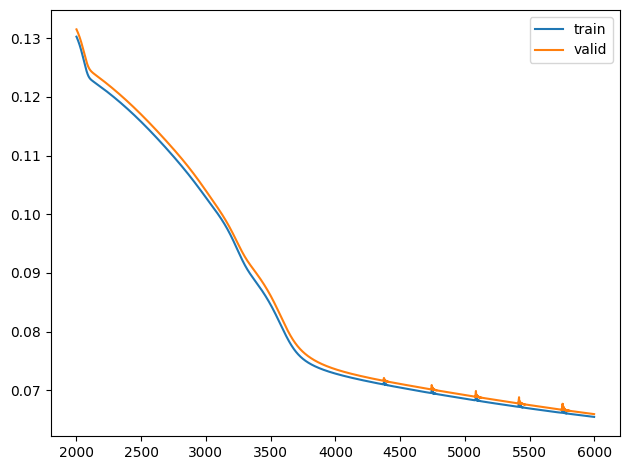

In [145]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
start_step = 2000
ax.plot(range(start_step, nsteps), train_loss_history[start_step:nsteps], label = "train")
ax.plot(range(start_step, nsteps), valid_loss_history[start_step:nsteps], label = "valid")
# ax.plot(range(start_step, nsteps), test_loss_history[start_step:nsteps], label = "test")
ax.legend(loc="upper right")
fig.tight_layout()
fig.show()

In [146]:
print(-jnp.log(output[0][0]))
print(-jnp.log(output[0][1]))
print(jnp.acos(output[0][2]) * 180 / jnp.pi)

0.9483370311169388
0.8243544844968667
111.86975614365711


In [147]:
from h2opes_analytic import water_pes
r_exact = 0.95
t_exact = 104.5 * jnp.pi / 180
theta = jnp.arange(jnp.pi/3, jnp.pi, 0.01)
bond = jnp.arange(0.8, 1.2, 0.005)
angle_vary = jnp.array([[r_exact, r_exact, t] for t in theta])
bond_vary = jnp.array([[r, r, t_exact] for r in bond])
batched_pes = jax.vmap(water_pes)
pes_angle_exact = batched_pes(angle_vary) / 1e4
pes_bond_exact = batched_pes(bond_vary) / 1e4

In [148]:
get_input = lambda x: jnp.array([jnp.exp(-x[0]), jnp.exp(-x[1]), jnp.cos(x[2])])
batched_input = jax.vmap(get_input)
angle_input = batched_input(angle_vary)
bond_input = batched_input(bond_vary)
angle_tau = flow_forward(params, angle_input)
bond_tau = flow_forward(params, bond_input)
batched_pot = jax.vmap(harmonic_potential, (0, None), 0)
pes_angle_reg = batched_pot(angle_tau, u0)
pes_bond_reg = batched_pot(bond_tau, u0)

/var/folders/hf/60jhbx_s40b92cvfxl5gbbb80000gn/T/ipykernel_4844/3375021634.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_.show()


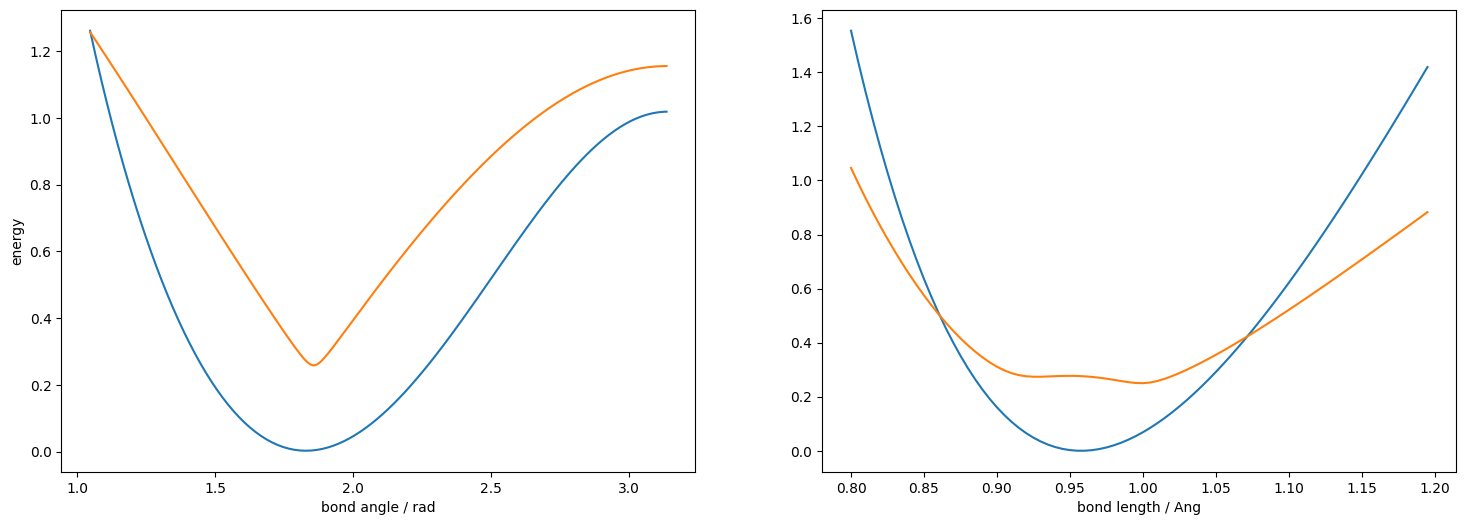

In [149]:
fig_ = plt.figure(figsize=(18, 6))
ax_ = fig_.subplots(1, 2)
ax_[0].plot(theta, pes_angle_exact)
ax_[0].plot(theta, pes_angle_reg)
ax_[0].set_xlabel("bond angle / rad")
ax_[0].set_ylabel("energy")
ax_[1].plot(bond, pes_bond_exact)
ax_[1].plot(bond, pes_bond_reg)
ax_[1].set_xlabel("bond length / Ang")
fig_.show()